Implementation of Grad-CAM [1] based on:
> Chollet, F. (2018). Deep learning with Python (Vol. 361). New York: Manning.

[1] Selvaraju, R. R., Cogswell, M., Das, A., Vedantam, R., Parikh, D., & Batra, D. (2017). Grad-CAM: Visual explanations from deep networks via gradient-based localization. In Proceedings of the IEEE international conference on computer vision (pp. 618-626).

# Reading inputs

In [1]:
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
with open('/work/omicsbio/paulcalle/Kidney_project/kidney_data/a_images_1D.npy', 'rb') as f:
    a_images_1D = np.load(f)
    
with open('/work/omicsbio/paulcalle/Kidney_project/kidney_data/a_label.npy', 'rb') as f:
    a_label = np.load(f)

In [3]:
with open('/work/omicsbio/paulcalle/Kidney_project/kidney_data/a_kidney_num.npy', 'rb') as f:
    a_kidney_num = np.load(f)

In [4]:
a_kidney_num.shape

(30000,)

In [5]:
a_images_1D.shape

(30000, 301, 235)

In [6]:
np.mean(a_images_1D)

51.38519326735939

In [7]:
a_images_1D.shape

(30000, 301, 235)

In [8]:
a_label

array(['medulla', 'medulla', 'medulla', ..., 'medulla', 'medulla',
       'medulla'], dtype='<U12')

# Transforming labels to numerical categories

In [9]:
a_label_num = np.copy(a_label)

In [10]:
a_label_num[a_label_num == "medulla"] = 0
a_label_num[a_label_num == "cortex"] = 1
a_label_num[a_label_num == "pelvis_calyx"] = 2

In [11]:
a_label_num = a_label_num.astype(int)

In [12]:
a_label_num

array([0, 0, 0, ..., 0, 0, 0])

In [13]:
 a_images_1D

array([[[ 7,  0, 17, ...,  7, 10, 10],
        [ 0, 18, 19, ...,  0,  0,  2],
        [ 9, 12, 64, ..., 24, 31, 37],
        ...,
        [14,  6, 19, ..., 15, 39, 11],
        [ 6,  0, 15, ..., 17, 42, 13],
        [ 0,  0,  4, ...,  9, 33,  3]],

       [[54,  4,  0, ..., 11, 20, 16],
        [57, 19, 10, ...,  1, 10, 11],
        [20,  3,  3, ...,  0,  1,  3],
        ...,
        [ 7,  0, 15, ..., 10, 11, 12],
        [15,  1, 18, ..., 18, 20, 23],
        [18, 18, 13, ...,  0,  0,  0]],

       [[ 6,  0, 15, ..., 17,  0,  7],
        [ 7,  1, 10, ..., 17,  2, 13],
        [ 8,  7, 17, ...,  0,  0, 26],
        ...,
        [18, 32,  0, ...,  2, 15,  1],
        [19, 33,  0, ...,  3, 16,  2],
        [ 9, 22,  0, ...,  4, 17,  2]],

       ...,

       [[ 8,  0,  0, ..., 12, 13, 12],
        [ 0,  1, 11, ...,  3,  5,  6],
        [12,  6, 13, ...,  3,  5,  8],
        ...,
        [11,  4,  5, ...,  3,  6,  8],
        [ 6,  2,  5, ...,  2,  4,  6],
        [22,  9,  0, ...,  6,  8

In [14]:
a_images_1D_float64 = a_images_1D.astype(float)

In [15]:
a_images_1D_float64.dtype

dtype('float64')

# Kidney 5

In [16]:
from tensorflow.keras import backend as K
K.clear_session()

In [17]:
model_K5 = keras.models.load_model("/scratch/paulcalle/kidney_results/summit/archRESNET50_outer_results_w_model/model_outer_K5.h5")

## Preprocess

In [18]:
index = 5

print("**Kidney test**: " + str(index) )

bool_kidney_train = a_kidney_num != index
bool_kidney_test = ~bool_kidney_train

X_train_raw, X_test_raw = a_images_1D[bool_kidney_train], a_images_1D[bool_kidney_test]
y_train, y_test = a_label_num[bool_kidney_train], a_label_num[bool_kidney_test]

# Preprocessing data
# Substracting the mean pixel
# (This is done normally per channel)
mean_train_raw = np.mean(X_train_raw)

X_train = X_train_raw - mean_train_raw
X_test = X_test_raw - mean_train_raw

**Kidney test**: 5


In [19]:
model_K5.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 301, 235, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 307, 241, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 151, 118, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 151, 118, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

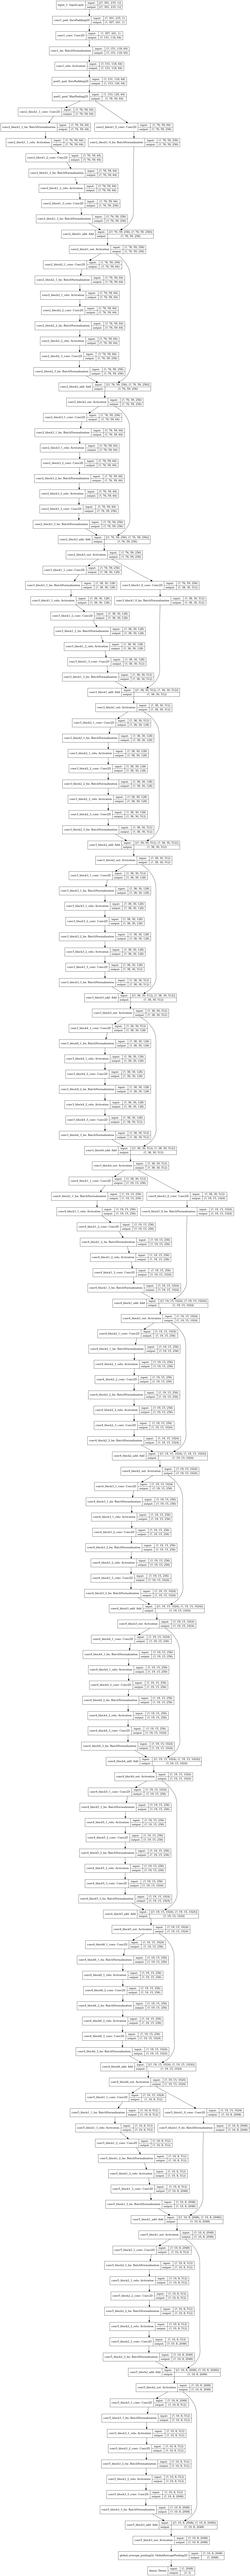

In [20]:
keras.utils.plot_model(model_K5, "model_50_K5.png", show_shapes=True)

## Read images

Chen used in the paper:
* Medulla: 667
* Cortex: 667
* Calyx: 137

2 images for each tissue type were added

In [197]:
img_medulla_1.shape

(301, 235, 3)

In [198]:
img_medulla_1[:,:,0][np.newaxis,...].shape

(1, 301, 235)

# Preprocess and Predict

## Resnet50

In [16]:
model_K5_tl = keras.models.load_model("/scratch/paulcalle/kidney_results/summit/archRESNET50_tf_outer_results_w_model/model_outer_b_K1.h5")

In [17]:
model_K5 = keras.models.load_model("/scratch/paulcalle/kidney_results/summit/archRESNET50_outer_results_w_model/model_outer_K5.h5")

In [18]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
  
# Read Images 
img_medulla_1 = mpimg.imread('/scratch/paulcalle/kidney_images/k5/k5_medulla/667_k5_medulla.jpg', format = "jpg") 

In [19]:
# Read Images 
img_medulla_2 = mpimg.imread('/scratch/paulcalle/kidney_images/k5/k5_medulla/134_k5_medulla.jpg', format = "jpg") 

In [20]:
# Read Images 
img_medulla_3 = mpimg.imread('/scratch/paulcalle/kidney_images/k5/k5_medulla/451_k5_medulla.jpg', format = "jpg") 

In [21]:
# Read Images 
img_cortex_1 = mpimg.imread('/scratch/paulcalle/kidney_images/k5/k5_cortex/667_k5_cortex.jpg', format = "jpg") 

In [22]:
# Read Images 
img_cortex_2 = mpimg.imread('/scratch/paulcalle/kidney_images/k5/k5_cortex/233_k5_cortex.jpg', format = "jpg") 

In [23]:
# Read Images 
img_cortex_3 = mpimg.imread('/scratch/paulcalle/kidney_images/k5/k5_cortex/421_k5_cortex.jpg', format = "jpg") 

In [24]:
# Read Images 
img_pelvis_calyx_1 = mpimg.imread('/scratch/paulcalle/kidney_images/k5/k5_pelvis_calyx/137_k5_pelvis_calyx.jpg', format = "jpg") 

In [25]:
# Read Images 
img_pelvis_calyx_2 = mpimg.imread('/scratch/paulcalle/kidney_images/k5/k5_pelvis_calyx/250_k5_pelvis_calyx.jpg', format = "jpg") 

In [26]:
# Read Images 
img_pelvis_calyx_3 = mpimg.imread('/scratch/paulcalle/kidney_images/k5/k5_pelvis_calyx/650_k5_pelvis_calyx.jpg', format = "jpg") 

In [27]:
# Read Images 
img_pelvis_calyx_new1 = mpimg.imread('/scratch/paulcalle/Calyx_images/calyx1.jpg', format = "jpg") 

In [28]:
# Read Images 
img_pelvis_calyx_new2 = mpimg.imread('/scratch/paulcalle/Calyx_images/calyx2.jpg', format = "jpg") 

In [29]:
# Read Images 
img_pelvis_calyx_new3 = mpimg.imread('/scratch/paulcalle/Calyx_images/calyx3.jpg', format = "jpg") 

In [30]:
img_medulla_1_pre_processed = (img_medulla_1[:,:,0] - mean_train_raw)[np.newaxis,...,np.newaxis]
img_medulla_1_pre_processed.shape

NameError: name 'mean_train_raw' is not defined

In [214]:
X_test.shape

(3000, 301, 235)

In [215]:
model_K5.predict(X_test[0][np.newaxis, ..., np.newaxis])

array([[3.0598192e-02, 9.6938288e-01, 1.8940475e-05]], dtype=float32)

In [217]:
img_medulla_2_pre_processed = (img_medulla_2[:,:,0] - mean_train_raw)[np.newaxis,...,np.newaxis]
img_medulla_2_pre_processed.shape

(1, 301, 235, 1)

In [218]:
model_K5.predict(img_medulla_2_pre_processed)

array([[9.9965680e-01, 3.4316222e-04, 1.3009945e-10]], dtype=float32)

In [219]:
img_medulla_3_pre_processed = (img_medulla_3[:,:,0] - mean_train_raw)[np.newaxis,...,np.newaxis]
img_medulla_3_pre_processed.shape

(1, 301, 235, 1)

In [220]:
model_K5.predict(img_medulla_3_pre_processed)

array([[9.9966455e-01, 3.3548943e-04, 4.4208235e-12]], dtype=float32)

In [221]:
img_cortex_1_pre_processed = (img_cortex_1[:,:,0] - mean_train_raw)[np.newaxis,...,np.newaxis]
img_cortex_1_pre_processed.shape

(1, 301, 235, 1)

In [222]:
model_K5.predict(img_cortex_1_pre_processed)

array([[2.8799661e-02, 9.7114199e-01, 5.8393594e-05]], dtype=float32)

In [223]:
img_cortex_2_pre_processed = (img_cortex_2[:,:,0] - mean_train_raw)[np.newaxis,...,np.newaxis]
img_cortex_2_pre_processed.shape

(1, 301, 235, 1)

In [224]:
model_K5.predict(img_cortex_2_pre_processed)

array([[3.0328372e-02, 9.6966052e-01, 1.1136647e-05]], dtype=float32)

In [225]:
img_cortex_3_pre_processed = (img_cortex_3[:,:,0] - mean_train_raw)[np.newaxis,...,np.newaxis]
img_cortex_3_pre_processed.shape

(1, 301, 235, 1)

In [226]:
model_K5.predict(img_cortex_3_pre_processed)

array([[6.78027328e-03, 9.93104398e-01, 1.15362076e-04]], dtype=float32)

In [227]:
img_pelvis_calyx_1_pre_processed = (img_pelvis_calyx_1[:,:,0] - mean_train_raw)[np.newaxis,...,np.newaxis]
img_pelvis_calyx_1_pre_processed.shape

(1, 301, 235, 1)

In [228]:
model_K5.predict(img_pelvis_calyx_1_pre_processed)

array([[3.3859146e-14, 3.7479199e-12, 1.0000000e+00]], dtype=float32)

In [229]:
img_pelvis_calyx_2_pre_processed = (img_pelvis_calyx_2[:,:,0] - mean_train_raw)[np.newaxis,...,np.newaxis]
img_pelvis_calyx_2_pre_processed.shape

(1, 301, 235, 1)

In [230]:
model_K5.predict(img_pelvis_calyx_2_pre_processed)

array([[8.1225619e-13, 9.0137793e-13, 1.0000000e+00]], dtype=float32)

In [231]:
img_pelvis_calyx_3_pre_processed = (img_pelvis_calyx_2[:,:,0] - mean_train_raw)[np.newaxis,...,np.newaxis]
img_pelvis_calyx_3_pre_processed.shape

(1, 301, 235, 1)

In [232]:
model_K5.predict(img_pelvis_calyx_3_pre_processed)

array([[8.1225619e-13, 9.0137793e-13, 1.0000000e+00]], dtype=float32)

In [233]:
# Read Images 
img_pelvis_calyx_new1_pre_processed = (img_pelvis_calyx_new1[:,:,0] - mean_train_raw)[np.newaxis,...,np.newaxis]
# Read Images 
img_pelvis_calyx_new1_pre_processed.shape

(1, 301, 235, 1)

In [234]:
model_K5.predict(img_pelvis_calyx_new1_pre_processed)

array([[5.7528644e-07, 4.7108169e-05, 9.9995232e-01]], dtype=float32)

In [235]:
# Read Images 
img_pelvis_calyx_new2_pre_processed = (img_pelvis_calyx_new2[:,:,0] - mean_train_raw)[np.newaxis,...,np.newaxis]
# Read Images 
img_pelvis_calyx_new2_pre_processed.shape

(1, 301, 235, 1)

In [236]:
# Read Images 
img_pelvis_calyx_new3_pre_processed = (img_pelvis_calyx_new3[:,:,0] - mean_train_raw)[np.newaxis,...,np.newaxis]
# Read Images 
img_pelvis_calyx_new3_pre_processed.shape

(1, 301, 235, 1)

## Resnet50 TL

In [16]:
model_K5_tl = keras.models.load_model("/scratch/paulcalle/kidney_results/summit/archRESNET50_tf_outer_results_w_model/model_outer_b_K1.h5")

In [31]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
  
# Read Images 
img_medulla_1 = mpimg.imread('/scratch/paulcalle/kidney_images/k5/k5_medulla/667_k5_medulla.jpg', format = "jpg") 

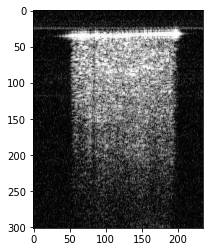

In [32]:
plt.imshow(img_medulla_1)

In [33]:
img_medulla_1.shape

(301, 235, 3)

In [34]:
img_medulla_1

array([[[ 1,  1,  1],
        [19, 19, 19],
        [ 0,  0,  0],
        ...,
        [ 7,  7,  7],
        [18, 18, 18],
        [ 1,  1,  1]],

       [[ 2,  2,  2],
        [19, 19, 19],
        [ 0,  0,  0],
        ...,
        [ 9,  9,  9],
        [17, 17, 17],
        [ 0,  0,  0]],

       [[ 2,  2,  2],
        [14, 14, 14],
        [ 0,  0,  0],
        ...,
        [18, 18, 18],
        [24, 24, 24],
        [ 2,  2,  2]],

       ...,

       [[ 0,  0,  0],
        [10, 10, 10],
        [17, 17, 17],
        ...,
        [29, 29, 29],
        [24, 24, 24],
        [35, 35, 35]],

       [[ 0,  0,  0],
        [13, 13, 13],
        [11, 11, 11],
        ...,
        [11, 11, 11],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 1,  1,  1],
        [18, 18, 18],
        [ 7,  7,  7],
        ...,
        [31, 31, 31],
        [12, 12, 12],
        [ 5,  5,  5]]], dtype=uint8)

In [35]:
print("images_resized")
images_resized = tf.image.resize_with_pad(img_medulla_1, 224, 224, antialias=True)
img_medulla_1_preprocessed_resnet50tf = images_resized.numpy()
del images_resized

# with tf.device('/CPU:0'):
#     images_resized = tf.image.resize_with_pad(img_medulla_1, 224, 224, antialias=True)
#     np_images_resized = images_resized.numpy()
#     del images_resized
# del a_images_3D

images_resized


In [36]:
img_medulla_1_preprocessed_resnet50tf

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

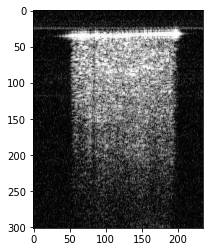

In [37]:
plt.imshow(img_medulla_1)

In [43]:
img_medulla_1_preprocessed_resnet50tf

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

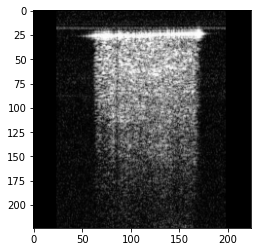

In [39]:
plt.imshow(img_medulla_1_preprocessed_resnet50tf/np.max(img_medulla_1_preprocessed_resnet50tf))

In [40]:
np.max(img_medulla_1_preprocessed_resnet50tf)

254.68045

In [41]:
img_medulla_1_resnet50tf_input = keras.applications.resnet50.preprocess_input(np.copy(img_medulla_1_preprocessed_resnet50tf))[np.newaxis, ...]

In [42]:
img_medulla_1_resnet50tf_input.shape

(1, 224, 224, 3)

In [38]:
model_K5_tl.predict(img_medulla_1_resnet50tf_input)

array([[1.0000000e+00, 9.4659415e-14, 0.0000000e+00]], dtype=float32)

In [45]:
print("images_resized")
images_resized = tf.image.resize_with_pad(img_medulla_2, 224, 224, antialias=True)
img_medulla_2_preprocessed_resnet50tf = images_resized.numpy()
del images_resized

img_medulla_2_resnet50tf_input = keras.applications.resnet50.preprocess_input(np.copy(img_medulla_2_preprocessed_resnet50tf))[np.newaxis,...]

model_K5_tl.predict(img_medulla_2_resnet50tf_input)
# with tf.device('/CPU:0'):
#     images_resized = tf.image.resize_with_pad(img_medulla_1, 224, 224, antialias=True)
#     np_images_resized = images_resized.numpy()
#     del images_resized
# del a_images_3D

images_resized


array([[1.0000000e+00, 1.0767813e-08, 0.0000000e+00]], dtype=float32)

In [46]:
print("images_resized")
images_resized = tf.image.resize_with_pad(img_medulla_3, 224, 224, antialias=True)
img_medulla_3_preprocessed_resnet50tf = images_resized.numpy()
del images_resized

img_medulla_3_resnet50tf_input = keras.applications.resnet50.preprocess_input(np.copy(img_medulla_3_preprocessed_resnet50tf))[np.newaxis,...]

model_K5_tl.predict(img_medulla_3_resnet50tf_input)
# with tf.device('/CPU:0'):
#     images_resized = tf.image.resize_with_pad(img_medulla_1, 224, 224, antialias=True)
#     np_images_resized = images_resized.numpy()
#     del images_resized
# del a_images_3D

images_resized


array([[9.9996018e-01, 3.9843399e-05, 1.8291971e-29]], dtype=float32)

In [42]:
img_cortex_1.shape

(301, 235, 3)

In [47]:
print("images_resized")
images_resized = tf.image.resize_with_pad(img_cortex_1, 224, 224, antialias=True)
img_cortex_1_preprocessed_resnet50tf = images_resized.numpy()
del images_resized

img_cortex_1_resnet50tf_input = keras.applications.resnet50.preprocess_input(np.copy(img_cortex_1_preprocessed_resnet50tf))[np.newaxis,...]

model_K5_tl.predict(img_cortex_1_resnet50tf_input)
# with tf.device('/CPU:0'):
#     images_resized = tf.image.resize_with_pad(img_medulla_1, 224, 224, antialias=True)
#     np_images_resized = images_resized.numpy()
#     del images_resized
# del a_images_3D

images_resized


array([[8.748724e-05, 9.999031e-01, 9.364708e-06]], dtype=float32)

In [48]:
print("images_resized")
images_resized = tf.image.resize_with_pad(img_cortex_2, 224, 224, antialias=True)
img_cortex_2_preprocessed_resnet50tf = images_resized.numpy()
del images_resized

img_cortex_2_resnet50tf_input = keras.applications.resnet50.preprocess_input(np.copy(img_cortex_2_preprocessed_resnet50tf))[np.newaxis,...]

model_K5_tl.predict(img_cortex_2_resnet50tf_input)
# with tf.device('/CPU:0'):
#     images_resized = tf.image.resize_with_pad(img_medulla_1, 224, 224, antialias=True)
#     np_images_resized = images_resized.numpy()
#     del images_resized
# del a_images_3D

images_resized


array([[6.521455e-05, 9.999342e-01, 5.325099e-07]], dtype=float32)

In [49]:
print("images_resized")
images_resized = tf.image.resize_with_pad(img_cortex_3, 224, 224, antialias=True)
img_cortex_3_preprocessed_resnet50tf = images_resized.numpy()
del images_resized

img_cortex_3_resnet50tf_input = keras.applications.resnet50.preprocess_input(np.copy(img_cortex_3_preprocessed_resnet50tf))[np.newaxis,...]

model_K5_tl.predict(img_cortex_3_resnet50tf_input)
# with tf.device('/CPU:0'):
#     images_resized = tf.image.resize_with_pad(img_medulla_1, 224, 224, antialias=True)
#     np_images_resized = images_resized.numpy()
#     del images_resized
# del a_images_3D

images_resized


array([[2.6247937e-03, 9.9706954e-01, 3.0567611e-04]], dtype=float32)

In [50]:
print("images_resized")
images_resized = tf.image.resize_with_pad(img_pelvis_calyx_1, 224, 224, antialias=True)
img_pelvis_calyx_1_preprocessed_resnet50tf = images_resized.numpy()
del images_resized

img_pelvis_calyx_1_resnet50tf_input = keras.applications.resnet50.preprocess_input(np.copy(img_pelvis_calyx_1_preprocessed_resnet50tf))[np.newaxis,...]

model_K5_tl.predict(img_pelvis_calyx_1_resnet50tf_input)
# with tf.device('/CPU:0'):
#     images_resized = tf.image.resize_with_pad(img_medulla_1, 224, 224, antialias=True)
#     np_images_resized = images_resized.numpy()
#     del images_resized
# del a_images_3D

images_resized


array([[1.8921978e-07, 1.8578270e-07, 9.9999952e-01]], dtype=float32)

In [51]:
print("images_resized")
images_resized = tf.image.resize_with_pad(img_pelvis_calyx_2, 224, 224, antialias=True)
img_pelvis_calyx_2_preprocessed_resnet50tf = images_resized.numpy()
del images_resized

img_pelvis_calyx_2_resnet50tf_input = keras.applications.resnet50.preprocess_input(np.copy(img_pelvis_calyx_2_preprocessed_resnet50tf))[np.newaxis,...]

model_K5_tl.predict(img_pelvis_calyx_2_resnet50tf_input)
# with tf.device('/CPU:0'):
#     images_resized = tf.image.resize_with_pad(img_medulla_1, 224, 224, antialias=True)
#     np_images_resized = images_resized.numpy()
#     del images_resized
# del a_images_3D

images_resized


array([[3.4745705e-07, 1.7606655e-07, 9.9999952e-01]], dtype=float32)

In [52]:
print("images_resized")
images_resized = tf.image.resize_with_pad(img_pelvis_calyx_3, 224, 224, antialias=True)
img_pelvis_calyx_3_preprocessed_resnet50tf = images_resized.numpy()
del images_resized

img_pelvis_calyx_3_resnet50tf_input = keras.applications.resnet50.preprocess_input(np.copy(img_pelvis_calyx_3_preprocessed_resnet50tf))[np.newaxis,...]

model_K5_tl.predict(img_pelvis_calyx_3_resnet50tf_input)
# with tf.device('/CPU:0'):
#     images_resized = tf.image.resize_with_pad(img_medulla_1, 224, 224, antialias=True)
#     np_images_resized = images_resized.numpy()
#     del images_resized
# del a_images_3D

images_resized


array([[1.9304457e-06, 1.0418999e-03, 9.9895620e-01]], dtype=float32)

In [53]:
print("images_resized")
images_resized = tf.image.resize_with_pad(img_pelvis_calyx_new1, 224, 224, antialias=True)
img_pelvis_calyx_new1_preprocessed_resnet50tf = images_resized.numpy()
del images_resized

img_pelvis_calyx_new1_resnet50tf_input = keras.applications.resnet50.preprocess_input(np.copy(img_pelvis_calyx_new1_preprocessed_resnet50tf))[np.newaxis,...]

model_K5_tl.predict(img_pelvis_calyx_new1_resnet50tf_input)
# with tf.device('/CPU:0'):
#     images_resized = tf.image.resize_with_pad(img_medulla_1, 224, 224, antialias=True)
#     np_images_resized = images_resized.numpy()
#     del images_resized
# del a_images_3D

images_resized


array([[1.9695735e-04, 3.7838174e-05, 9.9976522e-01]], dtype=float32)

In [54]:
print("images_resized")
images_resized = tf.image.resize_with_pad(img_pelvis_calyx_new2, 224, 224, antialias=True)
img_pelvis_calyx_new2_preprocessed_resnet50tf = images_resized.numpy()
del images_resized

img_pelvis_calyx_new2_resnet50tf_input = keras.applications.resnet50.preprocess_input(np.copy(img_pelvis_calyx_new2_preprocessed_resnet50tf))[np.newaxis,...]

model_K5_tl.predict(img_pelvis_calyx_new2_resnet50tf_input)
# with tf.device('/CPU:0'):
#     images_resized = tf.image.resize_with_pad(img_medulla_1, 224, 224, antialias=True)
#     np_images_resized = images_resized.numpy()
#     del images_resized
# del a_images_3D

images_resized


array([[1.2345250e-04, 3.4172426e-05, 9.9984229e-01]], dtype=float32)

In [55]:
print("images_resized")
images_resized = tf.image.resize_with_pad(img_pelvis_calyx_new3, 224, 224, antialias=True)
img_pelvis_calyx_new3_preprocessed_resnet50tf = images_resized.numpy()
del images_resized

img_pelvis_calyx_new3_resnet50tf_input = keras.applications.resnet50.preprocess_input(np.copy(img_pelvis_calyx_new3_preprocessed_resnet50tf))[np.newaxis,...]

model_K5_tl.predict(img_pelvis_calyx_new3_resnet50tf_input)
# with tf.device('/CPU:0'):
#     images_resized = tf.image.resize_with_pad(img_medulla_1, 224, 224, antialias=True)
#     np_images_resized = images_resized.numpy()
#     del images_resized
# del a_images_3D

images_resized


array([[2.749161e-04, 2.189544e-05, 9.997031e-01]], dtype=float32)

# Resnet 50

## Medulla 1 Grad-CAM

In [237]:
from tensorflow.keras import backend as K
K.clear_session()

In [238]:
model_K5 = keras.models.load_model("/scratch/paulcalle/kidney_results/summit/archRESNET50_outer_results_w_model/model_outer_K5.h5")

In [239]:
model_K5.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 301, 235, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 307, 241, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 151, 118, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 151, 118, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [240]:
# There were some problems with K.gradients
# This lines solved it

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# Source: https://github.com/tensorflow/tensorflow/issues/33135

In [241]:
# This is the "medulla" entry in the prediction vector
medulla_output = model_K5.output[:, 0]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(medulla_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_medulla_1_pre_processed])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [242]:
import matplotlib.pyplot as plt

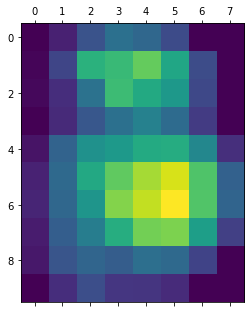

In [243]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [244]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (X_test[0].shape[1], X_test[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.6 + img_medulla_1


# Save the image to disk
cv2.imwrite('./Grad-CAM_images/test_kidney_5_medulla_1_0.6.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (301, 235, 3)
heatmap[0][0] =  [128   0   0]


True

## Medulla 2 Grad-CAM

In [245]:
from tensorflow.keras import backend as K
K.clear_session()

In [246]:
model_K5 = keras.models.load_model("/scratch/paulcalle/kidney_results/summit/archRESNET50_outer_results_w_model/model_outer_K5.h5")

In [247]:
# There were some problems with K.gradients
# This lines solved it

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# Source: https://github.com/tensorflow/tensorflow/issues/33135

In [248]:
# This is the "medulla" entry in the prediction vector
medulla_output = model_K5.output[:, 0]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(medulla_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_medulla_2_pre_processed])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [249]:
import matplotlib.pyplot as plt

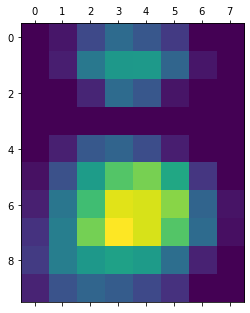

In [250]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [251]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (X_test[0].shape[1], X_test[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.6 + img_medulla_2


# Save the image to disk
cv2.imwrite('./Grad-CAM_images/test_kidney_5_medulla_2_0.6.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (301, 235, 3)
heatmap[0][0] =  [128   0   0]


True

## Medulla 3 Grad-CAM

In [252]:
from tensorflow.keras import backend as K
K.clear_session()

In [253]:
model_K5 = keras.models.load_model("/scratch/paulcalle/kidney_results/summit/archRESNET50_outer_results_w_model/model_outer_K5.h5")

In [254]:
# There were some problems with K.gradients
# This lines solved it

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# Source: https://github.com/tensorflow/tensorflow/issues/33135

In [255]:
# This is the "medulla" entry in the prediction vector
medulla_output = model_K5.output[:, 0]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(medulla_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_medulla_3_pre_processed])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [256]:
import matplotlib.pyplot as plt

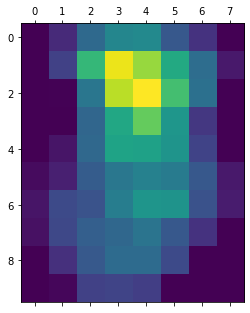

In [257]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [258]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (X_test[0].shape[1], X_test[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.6 + img_medulla_3


# Save the image to disk
cv2.imwrite('./Grad-CAM_images/test_kidney_5_medulla_3_06.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (301, 235, 3)
heatmap[0][0] =  [128   0   0]


True

## Cortex 1 Grad-CAM

In [259]:
from tensorflow.keras import backend as K
K.clear_session()

In [260]:
model_K5 = keras.models.load_model("/scratch/paulcalle/kidney_results/summit/archRESNET50_outer_results_w_model/model_outer_K5.h5")

In [261]:
# There were some problems with K.gradients
# This lines solved it

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# Source: https://github.com/tensorflow/tensorflow/issues/33135

In [262]:
# This is the "medulla" entry in the prediction vector
cortex_output = model_K5.output[:, 1]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(cortex_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_cortex_1_pre_processed])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [263]:
import matplotlib.pyplot as plt

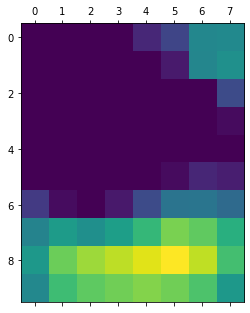

In [264]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [265]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (X_test[0].shape[1], X_test[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.6 + img_cortex_1


# Save the image to disk
cv2.imwrite('./Grad-CAM_images/test_kidney_5_cortex_1_06.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (301, 235, 3)
heatmap[0][0] =  [128   0   0]


True

## Cortex 2 Grad-CAM

In [266]:
from tensorflow.keras import backend as K
K.clear_session()

In [267]:
model_K5 = keras.models.load_model("/scratch/paulcalle/kidney_results/summit/archRESNET50_outer_results_w_model/model_outer_K5.h5")

In [268]:
# There were some problems with K.gradients
# This lines solved it

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# Source: https://github.com/tensorflow/tensorflow/issues/33135

In [269]:
# This is the "medulla" entry in the prediction vector
cortex_output = model_K5.output[:, 1]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(cortex_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_cortex_2_pre_processed])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [270]:
import matplotlib.pyplot as plt

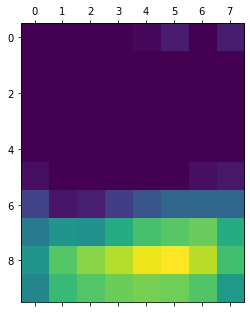

In [271]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [272]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (X_test[0].shape[1], X_test[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.6 + img_cortex_2


# Save the image to disk
cv2.imwrite('./Grad-CAM_images/test_kidney_5_cortex_2_06.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (301, 235, 3)
heatmap[0][0] =  [128   0   0]


True

## Cortex 3 Grad-CAM

In [273]:
from tensorflow.keras import backend as K
K.clear_session()

In [274]:
model_K5 = keras.models.load_model("/scratch/paulcalle/kidney_results/summit/archRESNET50_outer_results_w_model/model_outer_K5.h5")

In [275]:
# There were some problems with K.gradients
# This lines solved it

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# Source: https://github.com/tensorflow/tensorflow/issues/33135

In [276]:
# This is the "medulla" entry in the prediction vector
cortex_output = model_K5.output[:, 1]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(cortex_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_cortex_3_pre_processed])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [277]:
import matplotlib.pyplot as plt

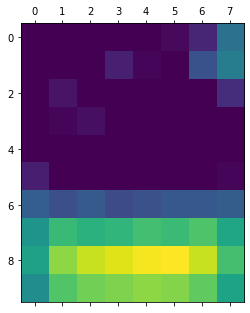

In [278]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [279]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (X_test[0].shape[1], X_test[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.6 + img_cortex_3


# Save the image to disk
cv2.imwrite('./Grad-CAM_images/test_kidney_5_cortex_3_06.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (301, 235, 3)
heatmap[0][0] =  [128   0   0]


True

## Pelvis 1 Calyx Grad-CAM

In [280]:
from tensorflow.keras import backend as K
K.clear_session()

In [281]:
model_K5 = keras.models.load_model("/scratch/paulcalle/kidney_results/summit/archRESNET50_outer_results_w_model/model_outer_K5.h5")

In [282]:
# There were some problems with K.gradients
# This lines solved it

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# Source: https://github.com/tensorflow/tensorflow/issues/33135

In [283]:
# This is the "medulla" entry in the prediction vector
pelvis_calyx_output = model_K5.output[:, 2]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(pelvis_calyx_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_pelvis_calyx_1_pre_processed])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [284]:
import matplotlib.pyplot as plt

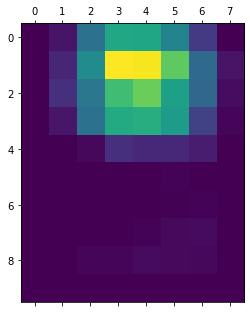

In [285]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [286]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (X_test[0].shape[1], X_test[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.6 + img_pelvis_calyx_1


# Save the image to disk
cv2.imwrite('./Grad-CAM_images/test_kidney_5_pelvis_calyx_1_06.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (301, 235, 3)
heatmap[0][0] =  [128   0   0]


True

## Pelvis 2 Calyx Grad-CAM

In [287]:
from tensorflow.keras import backend as K
K.clear_session()

In [288]:
model_K5 = keras.models.load_model("/scratch/paulcalle/kidney_results/summit/archRESNET50_outer_results_w_model/model_outer_K5.h5")

In [289]:
# There were some problems with K.gradients
# This lines solved it

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# Source: https://github.com/tensorflow/tensorflow/issues/33135

In [290]:
# This is the "medulla" entry in the prediction vector
pelvis_calyx_output = model_K5.output[:, 2]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(pelvis_calyx_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_pelvis_calyx_2_pre_processed])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [291]:
import matplotlib.pyplot as plt

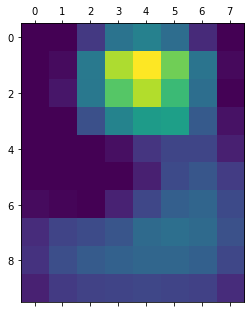

In [292]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [293]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (X_test[0].shape[1], X_test[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.6 + img_pelvis_calyx_2


# Save the image to disk
cv2.imwrite('./Grad-CAM_images/test_kidney_5_pelvis_calyx_2_06.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (301, 235, 3)
heatmap[0][0] =  [128   0   0]


True

## Pelvis 3 Calyx Grad-CAM

In [294]:
from tensorflow.keras import backend as K
K.clear_session()

In [295]:
model_K5 = keras.models.load_model("/scratch/paulcalle/kidney_results/summit/archRESNET50_outer_results_w_model/model_outer_K5.h5")

In [296]:
# There were some problems with K.gradients
# This lines solved it

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# Source: https://github.com/tensorflow/tensorflow/issues/33135

In [297]:
# This is the "medulla" entry in the prediction vector
pelvis_calyx_output = model_K5.output[:, 2]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(pelvis_calyx_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_pelvis_calyx_3_pre_processed])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [298]:
import matplotlib.pyplot as plt

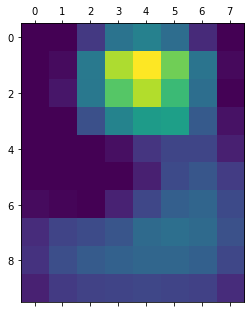

In [299]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [300]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (X_test[0].shape[1], X_test[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.6 + img_pelvis_calyx_3


# Save the image to disk
cv2.imwrite('./Grad-CAM_images/test_kidney_5_pelvis_calyx_3_06.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (301, 235, 3)
heatmap[0][0] =  [128   0   0]


True

## Pelvis 1 New Calyx Grad-CAM

In [301]:
from tensorflow.keras import backend as K
K.clear_session()

In [302]:
model_K5 = keras.models.load_model("/scratch/paulcalle/kidney_results/summit/archRESNET50_outer_results_w_model/model_outer_K5.h5")

In [303]:
# There were some problems with K.gradients
# This lines solved it

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# Source: https://github.com/tensorflow/tensorflow/issues/33135

In [304]:
# This is the "medulla" entry in the prediction vector
pelvis_calyx_output = model_K5.output[:, 2]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(pelvis_calyx_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_pelvis_calyx_new1_pre_processed])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [305]:
import matplotlib.pyplot as plt

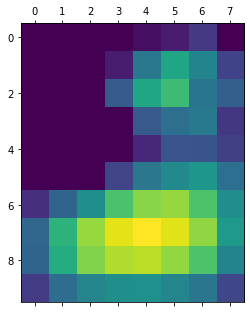

In [306]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [307]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (X_test[0].shape[1], X_test[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.6 + img_pelvis_calyx_new1


# Save the image to disk
cv2.imwrite('./Grad-CAM_images/test_kidney_5_pelvis_calyx_new1_06.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (301, 235, 3)
heatmap[0][0] =  [128   0   0]


True

## Pelvis 2 New Calyx Grad-CAM

In [327]:
from tensorflow.keras import backend as K
K.clear_session()

In [328]:
model_K5 = keras.models.load_model("/scratch/paulcalle/kidney_results/summit/archRESNET50_outer_results_w_model/model_outer_K5.h5")

In [329]:
# There were some problems with K.gradients
# This lines solved it

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# Source: https://github.com/tensorflow/tensorflow/issues/33135

In [330]:
# This is the "medulla" entry in the prediction vector
pelvis_calyx_output = model_K5.output[:, 2]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(pelvis_calyx_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_pelvis_calyx_new2_pre_processed])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [331]:
import matplotlib.pyplot as plt

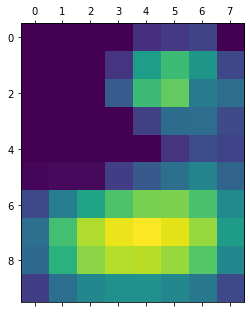

In [332]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [333]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (X_test[0].shape[1], X_test[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.6 + img_pelvis_calyx_new2


# Save the image to disk
cv2.imwrite('./Grad-CAM_images/test_kidney_5_pelvis_calyx_new2_06.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (301, 235, 3)
heatmap[0][0] =  [128   0   0]


True

## Pelvis 3 New Calyx Grad-CAM

In [318]:
from tensorflow.keras import backend as K
K.clear_session()

In [319]:
model_K5 = keras.models.load_model("/scratch/paulcalle/kidney_results/summit/archRESNET50_outer_results_w_model/model_outer_K5.h5")

In [320]:
# There were some problems with K.gradients
# This lines solved it

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# Source: https://github.com/tensorflow/tensorflow/issues/33135

In [321]:
# This is the "medulla" entry in the prediction vector
pelvis_calyx_output = model_K5.output[:, 2]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(pelvis_calyx_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_pelvis_calyx_new3_pre_processed])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [322]:
import matplotlib.pyplot as plt

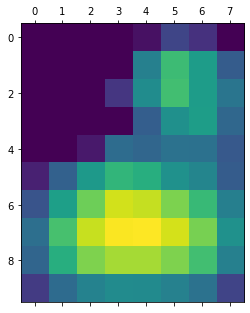

In [323]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [324]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (X_test[0].shape[1], X_test[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.6 + img_pelvis_calyx_new3


# Save the image to disk
cv2.imwrite('./Grad-CAM_images/test_kidney_5_pelvis_calyx_new3_06.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (301, 235)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (301, 235, 3)
heatmap[0][0] =  [128   0   0]


True

# ResNet 50 TL

## Medulla 1 Grad-CAM

In [61]:
# There were some problems with K.gradients
# This lines solved it

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# Source: https://github.com/tensorflow/tensorflow/issues/33135

In [62]:
from tensorflow.keras import backend as K
K.clear_session()

In [63]:
model_K5_tl = keras.models.load_model("/scratch/paulcalle/kidney_results/summit/archRESNET50_tf_outer_results_w_model/model_outer_b_K1.h5")

In [64]:
model_K5_tl.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

## Medulla 1

In [65]:
# This is the "medulla" entry in the prediction vector
medulla_output = model_K5_tl.output[:, 0]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5_tl.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(medulla_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5_tl.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_medulla_1_resnet50tf_input])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [66]:
import matplotlib.pyplot as plt

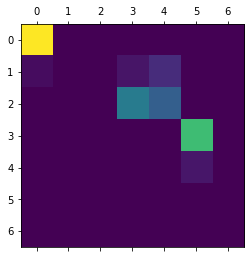

In [67]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [68]:
img_medulla_1_preprocessed_resnet50tf[0].shape[1]

3

In [69]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img_medulla_1_resnet50tf_input[0].shape[1], img_medulla_1_resnet50tf_input[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.4 + img_medulla_1_preprocessed_resnet50tf


# Save the image to disk
cv2.imwrite('/work/omicsbio/paulcalle/Kidney_project/Grad-CAM_images/ResNet50_TL/test_kidney_5_medulla_1_v04.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  1.0
1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  255
1:heatmap
heatmap.shape =  (224, 224, 3)
heatmap[0][0] =  [  0   0 128]


True

## Medulla 2

In [71]:
# This is the "medulla" entry in the prediction vector
medulla_output = model_K5_tl.output[:, 0]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5_tl.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(medulla_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5_tl.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_medulla_2_resnet50tf_input])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [72]:
import matplotlib.pyplot as plt

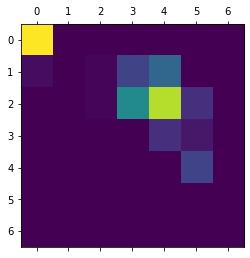

In [73]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [74]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img_medulla_1_resnet50tf_input[0].shape[1], img_medulla_1_resnet50tf_input[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.4 + img_medulla_2_preprocessed_resnet50tf


# Save the image to disk
cv2.imwrite('/work/omicsbio/paulcalle/Kidney_project/Grad-CAM_images/ResNet50_TL/test_kidney_5_medulla_2_v04.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  1.0
1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  255
1:heatmap
heatmap.shape =  (224, 224, 3)
heatmap[0][0] =  [  0   0 128]


True

## Medulla 3

In [75]:
# This is the "medulla" entry in the prediction vector
medulla_output = model_K5_tl.output[:, 0]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5_tl.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(medulla_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5_tl.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_medulla_3_resnet50tf_input])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [76]:
import matplotlib.pyplot as plt

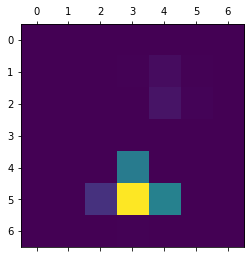

In [77]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [78]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img_medulla_1_resnet50tf_input[0].shape[1], img_medulla_1_resnet50tf_input[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.4 + img_medulla_3_preprocessed_resnet50tf


# Save the image to disk
cv2.imwrite('/work/omicsbio/paulcalle/Kidney_project/Grad-CAM_images/ResNet50_TL/test_kidney_5_medulla_3_v04.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (224, 224, 3)
heatmap[0][0] =  [128   0   0]


True

## Cortex 1

In [79]:
# This is the "medulla" entry in the prediction vector
medulla_output = model_K5_tl.output[:, 0]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5_tl.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(medulla_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5_tl.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_cortex_1_resnet50tf_input])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [80]:
import matplotlib.pyplot as plt

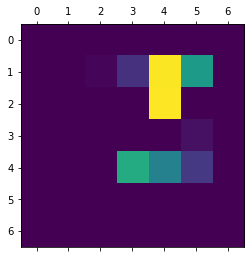

In [81]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [82]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img_medulla_1_resnet50tf_input[0].shape[1], img_medulla_1_resnet50tf_input[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.4 + img_cortex_1_preprocessed_resnet50tf


# Save the image to disk
cv2.imwrite('/work/omicsbio/paulcalle/Kidney_project/Grad-CAM_images/ResNet50_TL/test_kidney_5_cortex_1_v04.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (224, 224, 3)
heatmap[0][0] =  [128   0   0]


True

## Cortex 2

In [83]:
# This is the "medulla" entry in the prediction vector
medulla_output = model_K5_tl.output[:, 0]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5_tl.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(medulla_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5_tl.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_cortex_2_resnet50tf_input])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [84]:
import matplotlib.pyplot as plt

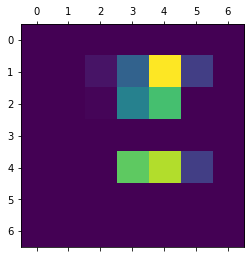

In [85]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [86]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img_medulla_1_resnet50tf_input[0].shape[1], img_medulla_1_resnet50tf_input[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.4 + img_cortex_2_preprocessed_resnet50tf


# Save the image to disk
cv2.imwrite('/work/omicsbio/paulcalle/Kidney_project/Grad-CAM_images/ResNet50_TL/test_kidney_5_cortex_2_v04.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (224, 224, 3)
heatmap[0][0] =  [128   0   0]


True

## Cortex 3

In [87]:
# This is the "medulla" entry in the prediction vector
medulla_output = model_K5_tl.output[:, 0]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5_tl.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(medulla_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5_tl.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_cortex_3_resnet50tf_input])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [88]:
import matplotlib.pyplot as plt

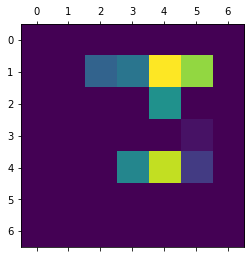

In [89]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [90]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img_medulla_1_resnet50tf_input[0].shape[1], img_medulla_1_resnet50tf_input[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.4 + img_cortex_3_preprocessed_resnet50tf


# Save the image to disk
cv2.imwrite('/work/omicsbio/paulcalle/Kidney_project/Grad-CAM_images/ResNet50_TL/test_kidney_5_cortex_3_v04.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (224, 224, 3)
heatmap[0][0] =  [128   0   0]


True

## Pelvis Calyx 1

In [91]:
# This is the "medulla" entry in the prediction vector
medulla_output = model_K5_tl.output[:, 0]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5_tl.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(medulla_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5_tl.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_pelvis_calyx_1_resnet50tf_input])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [92]:
import matplotlib.pyplot as plt

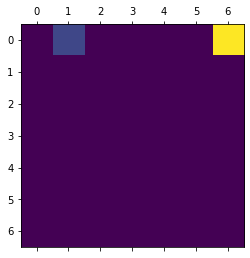

In [93]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [94]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img_medulla_1_resnet50tf_input[0].shape[1], img_medulla_1_resnet50tf_input[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.4 + img_pelvis_calyx_1_preprocessed_resnet50tf

# Save the image to disk
cv2.imwrite('/work/omicsbio/paulcalle/Kidney_project/Grad-CAM_images/ResNet50_TL/test_kidney_5_pelvis_calyx_1_v04.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (224, 224, 3)
heatmap[0][0] =  [128   0   0]


True

## Pelvis Calyx 2

In [95]:
# This is the "medulla" entry in the prediction vector
medulla_output = model_K5_tl.output[:, 0]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5_tl.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(medulla_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5_tl.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_pelvis_calyx_2_resnet50tf_input])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [96]:
import matplotlib.pyplot as plt

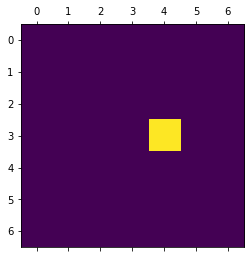

In [97]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [98]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img_medulla_1_resnet50tf_input[0].shape[1], img_medulla_1_resnet50tf_input[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.4 + img_pelvis_calyx_2_preprocessed_resnet50tf

# Save the image to disk
cv2.imwrite('/work/omicsbio/paulcalle/Kidney_project/Grad-CAM_images/ResNet50_TL/test_kidney_5_pelvis_calyx_2_v04.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (224, 224, 3)
heatmap[0][0] =  [128   0   0]


True

## Pelvis Calyx 3

In [99]:
# This is the "medulla" entry in the prediction vector
medulla_output = model_K5_tl.output[:, 0]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5_tl.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(medulla_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5_tl.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_pelvis_calyx_3_resnet50tf_input])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [100]:
import matplotlib.pyplot as plt

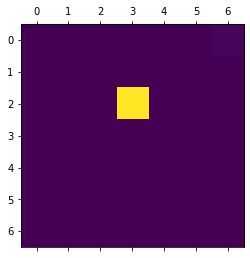

In [101]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [102]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img_medulla_1_resnet50tf_input[0].shape[1], img_medulla_1_resnet50tf_input[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.4 + img_pelvis_calyx_3_preprocessed_resnet50tf

# Save the image to disk
cv2.imwrite('/work/omicsbio/paulcalle/Kidney_project/Grad-CAM_images/ResNet50_TL/test_kidney_5_pelvis_calyx_3_v04.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (224, 224, 3)
heatmap[0][0] =  [128   0   0]


True

## Pelvis Calyx 1 New

In [107]:
# This is the "medulla" entry in the prediction vector
medulla_output = model_K5_tl.output[:, 0]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5_tl.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(medulla_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5_tl.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_pelvis_calyx_new1_resnet50tf_input])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [108]:
import matplotlib.pyplot as plt

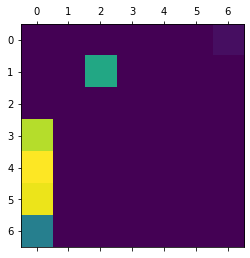

In [109]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [110]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img_medulla_1_resnet50tf_input[0].shape[1], img_medulla_1_resnet50tf_input[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.4 + img_pelvis_calyx_new1_preprocessed_resnet50tf

# Save the image to disk
cv2.imwrite('/work/omicsbio/paulcalle/Kidney_project/Grad-CAM_images/ResNet50_TL/test_kidney_5_pelvis_calyx_new1_v04.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (224, 224, 3)
heatmap[0][0] =  [128   0   0]


True

## Pelvis Calyx 2 New

In [111]:
# This is the "medulla" entry in the prediction vector
medulla_output = model_K5_tl.output[:, 0]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5_tl.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(medulla_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5_tl.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_pelvis_calyx_new2_resnet50tf_input])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [112]:
import matplotlib.pyplot as plt

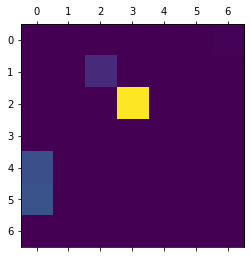

In [113]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [114]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img_medulla_1_resnet50tf_input[0].shape[1], img_medulla_1_resnet50tf_input[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.4 + img_pelvis_calyx_new2_preprocessed_resnet50tf

# Save the image to disk
cv2.imwrite('/work/omicsbio/paulcalle/Kidney_project/Grad-CAM_images/ResNet50_TL/test_kidney_5_pelvis_calyx_new2_v04.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (224, 224, 3)
heatmap[0][0] =  [128   0   0]


True

## Pelvis Calyx 3 New

In [115]:
# This is the "medulla" entry in the prediction vector
medulla_output = model_K5_tl.output[:, 0]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model_K5_tl.get_layer('conv5_block3_out')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(medulla_output, last_conv_layer.output)[0]
# grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (2048,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv5_block3_out`,
# given a sample image
iterate = K.function([model_K5_tl.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img_pelvis_calyx_new3_resnet50tf_input])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the medulla class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [116]:
import matplotlib.pyplot as plt

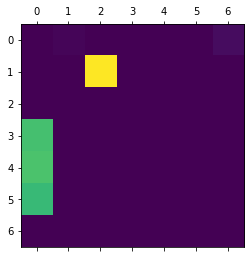

In [117]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [118]:
import cv2

# We use cv2 to load the original image
# img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img_medulla_1_resnet50tf_input[0].shape[1], img_medulla_1_resnet50tf_input[0].shape[0]))

print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print("1:heatmap")
print("heatmap.shape = ", heatmap.shape)
print("heatmap[0][0] = ", heatmap[0][0])

# 0.4 here is a heatmap intensity factor
# superimposed_img = heatmap[:,:,0] * 0.4 + X_test[0][..., np.newaxis]
superimposed_img = heatmap * 0.4 + img_pelvis_calyx_new3_preprocessed_resnet50tf

# Save the image to disk
cv2.imwrite('/work/omicsbio/paulcalle/Kidney_project/Grad-CAM_images/ResNet50_TL/test_kidney_5_pelvis_calyx_new3_v04.jpg', superimposed_img)

1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0.0
1:heatmap
heatmap.shape =  (224, 224)
heatmap[0][0] =  0
1:heatmap
heatmap.shape =  (224, 224, 3)
heatmap[0][0] =  [128   0   0]


True